In [2]:
!pip install numpy tensorflow matplotlib scipy
!pip install pandas
!pip install tifffile
!pip install scikit-learn
!pip install imagecodecs
!pip install tensorflow-addons

In [3]:
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install tensorflow
#!pip3 install tifffile
#!pip3 install -U scikit-learn scipy matplotlib
#!pip3 install imagecodecs
#!pip3 install tensorflow_decision_forests --upgrade

In [4]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install tifffile
!pip3 install -U scikit-learn scipy matplotlib
!pip3 install imagecodecs
!pip3 install tensorflow_decision_forests --upgrade

In [5]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
from keras.layers import Flatten, Dense, Dropout
import tifffile

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

import os

import scipy

2023-03-13 04:53:23.934253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 04:53:24.728205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 04:53:24.728232: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 04:53:26.847209: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [6]:
import math
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

In [7]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

In [8]:
tiles = pd.read_csv(r'Data/Tiles_expanded.csv')
tiles_expanded_rv = pd.read_csv(r'Data/Tiles_expanded_road_vector.csv').drop(['Unnamed: 0'],axis=1)
tiles_expanded_rv = pd.get_dummies(tiles_expanded_rv, columns = ['RTTYP'])

In [9]:
tiles_expanded_rv.head()

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


In [10]:
tiles_expanded_rv['Collisions_Future_binary']=tiles_expanded_rv['Collisions_Future'].apply(lambda x: 1 if x > 0 else 0)
tiles_expanded_rv['Collisions_Historical_binary']=tiles_expanded_rv['Collisions_Historical'].apply(lambda x: 1 if x > 0 else 0)

# Normalize data

In [11]:
def normalize_col(df, col_name):

    norm = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return norm

tiles_expanded_rv['Mid_lat_norm'] = normalize_col(tiles_expanded_rv,'Mid_lat')
tiles_expanded_rv['Mid_long_norm'] = normalize_col(tiles_expanded_rv,'Mid_long')


Split into training and test

In [12]:
MODEL_TYPE='logistic' # 'linear'

if MODEL_TYPE == 'linear':
    input_x = ['Tile_ID','Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = tiles_expanded_rv['Collisions_Future']
elif MODEL_TYPE == 'logistic':
    input_x = ['Tile_ID','Collisions_Historical_binary', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = ['Collisions_Future_binary']
    

x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_expanded_rv[input_x], 
                                    tiles_expanded_rv[input_y],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)



In [13]:
# np.asarray(x_train[['Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32').shape

Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

## Image Pre-Processing

In [14]:
IMAGE_PATH = '../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/' 

In [15]:
#eda
img = tifffile.imread('../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/37.tif')[0:148, 0:188, :]

In [16]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [17]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [18]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(np.mean(image))
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [19]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini = preprocess_data_part1(IMAGE_PATH)

In [20]:
np.shape(images_mini)

(8376,)

In [23]:
images_mini

array([125.19414, 130.83464, 145.29156, ..., 153.39537, 129.47469,
       121.93695], dtype=float32)

In [24]:
street_mini.reshape((8376,11))

array([[1.        , 0.40708277, 0.69343007, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00884366, 0.8394133 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.6283213 , 0.642334  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.07079828, 0.10949064, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.88495404, 0.5182463 , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.8672569 , 0.68613154, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [21]:
# images_mini_reshaped = images_mini.reshape((8376,1,1,111296))

In [22]:
# images_mini_reshaped.shape
# len(images_mini_reshaped[0][0][0])

Street Data Pre-Processing

In [21]:
street = np.asarray(x_train[input_x[1:]]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 11)

In [28]:
street_mini_reshaped = street_mini.reshape(8376,11)
np.shape(street_mini_reshaped)

(8376, 11)

In [33]:
images_mini_reshaped = images_mini.reshape(8376,1)
np.shape(images_mini_reshaped)

(8376, 1)

In [34]:
input_image_street = np.hstack((street_mini_reshaped, images_mini_reshaped))


In [25]:
# input_image_street = input_image_street.reshape((8376,1,1, 111307))

In [35]:
input_image_street[0]

array([  1.        ,   0.40708277,   0.69343007,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
         0.        ,   0.        ,   0.        , 125.19414   ],
      dtype=float32)

In [36]:
input_image_street.shape
# y_train.shape

(8376, 12)

In [37]:
np.shape(y_train)

(8376, 1)

**Model #3: Random Forest using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Helpful sources:

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
https://www.youtube.com/watch?v=5qgk9QJ4rdQ&t=181s

In [38]:
# Train a Random Forest model.

rf_model = tfdf.keras.RandomForestModel(task=2)

rf_model.fit(input_image_street,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpx2th5yut as temporary training directory
Reading training dataset...


2023-03-13 05:07:59.639784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 05:07:59.640687: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 05:07:59.640722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-91): /proc/driver/nvidia/version does not exist
2023-03-13 05:07:59.642351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:04.760717. Found 8376 examples.
Training model...


[INFO 2023-03-13T05:08:06.695664315+00:00 kernel.cc:1214] Loading model from path /tmp/tmpx2th5yut/model/ with prefix 37e204023a944d23


Model trained in 0:00:03.052378
Compiling model...


[INFO 2023-03-13T05:08:07.454330724+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 278780 node(s), and 11 input feature(s).
[INFO 2023-03-13T05:08:07.454374898+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-03-13T05:08:07.454414042+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [39]:
print(rf_model.summary())

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.0"  0.468187 ################
    2.  "data:0.3"  0.315831 #########
    3.  "data:0.2"  0.229193 ######
    4.  "data:0.5"  0.222719 #####
    5.  "data:0.1"  0.189987 ####
    6. "data:0.11"  0.154526 ##
    7.  "data:0.4"  0.102119 
    8.  "data:0.7"  0.085081 
    9. "data:0.10"  0.084205 
   10.  "data:0.9"  0.083766 
   11.  "data:0.6"  0.083294 

Variable Importance: NUM_AS_ROOT:
    1.  "data:0.0" 130.000000 ################
    2

In [40]:
##uncomment to show training log
#rf_model_train.make_inspector().training_logs()
rf_model.make_inspector().evaluation()

Evaluation(num_examples=8376, accuracy=None, loss=None, rmse=0.32093074703642993, ndcg=None, aucs=None, auuc=None, qini=None)

In [43]:
#evaluate the model
#rf_model.evaluate(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']])

In [44]:
#make predictions from test set
#pd.DataFrame(rf_model.predict(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]))

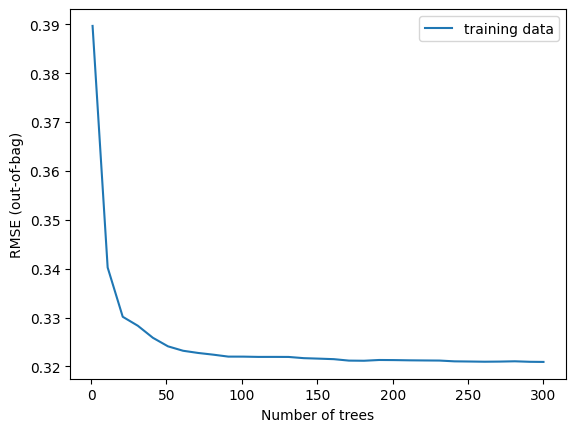

In [45]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.legend()
plt.show()

**Model #4: Gradient Boosted Tree using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Helpful sources:

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

In [46]:
gbt_model = tfdf.keras.GradientBoostedTreesModel(task=2)

gbt_model.fit(input_image_street,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpd7qpit_g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.323716. Found 8376 examples.
Training model...


2023-03-13 05:09:09.734951: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-13 05:09:09.734990: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-13 05:09:09.734999: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-13 05:09:09.735581: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to SQUARED_ERROR
2023-03-13 05:09:09.735624: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 8376 example(s) and 12 feature(s).
2023-03-13 05:09:09.736500: I 

Model trained in 0:00:00.738475
Compiling model...


2023-03-13 05:09:10.447298: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1568] Create final snapshot of the model at iteration 74
2023-03-13 05:09:10.449937: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 45 tree(s) i.e. 45  iteration(s).
2023-03-13 05:09:10.450126: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:45 valid-loss:0.311951 valid-rmse:0.311951
[INFO 2023-03-13T05:09:10.461611712+00:00 kernel.cc:1214] Loading model from path /tmp/tmpd7qpit_g/model/ with prefix e91e068dc8bb4fe1
[INFO 2023-03-13T05:09:10.467793553+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-03-13T05:09:10.467821127+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [47]:
print(gbt_model.summary())

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.0"  0.424873 ################
    2.  "data:0.3"  0.309196 ########
    3.  "data:0.5"  0.256201 #####
    4.  "data:0.2"  0.247375 ####
    5.  "data:0.1"  0.215822 ##
    6. "data:0.11"  0.215260 ##
    7.  "data:0.4"  0.189063 #
    8. "data:0.10"  0.172113 
    9.  "data:0.7"  0.171738 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 32.000000 ################
    2. "data:0.3"  5.000000 #
    3. "data:0.5"  5.00

In [48]:
##uncomment to show training log
#gbt_model.make_inspector().training_logs()
gbt_model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=None, loss=0.31195101141929626, rmse=0.31195101141929626, ndcg=None, aucs=None, auuc=None, qini=None)

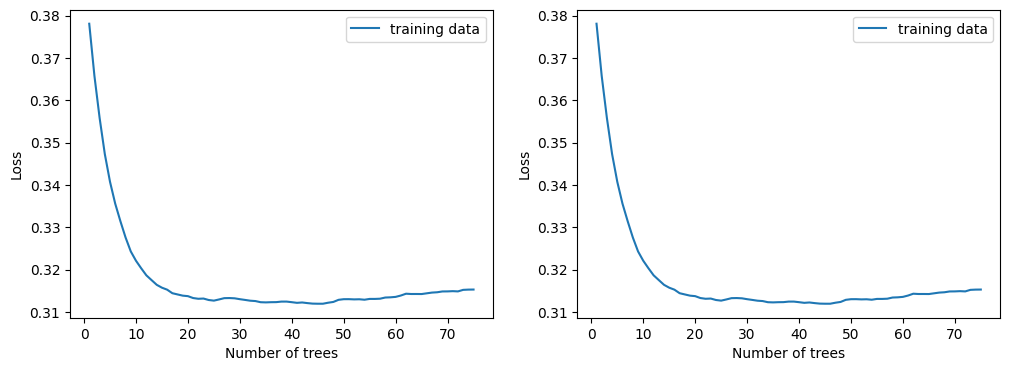

In [49]:
import matplotlib.pyplot as plt

logs = gbt_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [51]:
#evaluate the model
#gbt_model.evaluate(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']])

In [52]:
#make predictions from test set
#pd.DataFrame(gbt_model.predict(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]))